In [76]:
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import os
import numpy as np

import gfdl_utils.core as gu

In [111]:
def get_pathDict(pp, time="*"):
    ppname = "ocean_annual_z_d2"
    out = "ts"
    return {
        "pp": pp,
        "ppname": ppname,
        "out": out,
        "local": gu.get_local(pp, ppname, out),
        "time": time,
        "add": "agessc",
    }

pre = "/archive/Raphael.Dussin/datasets/"
sg = f"{pre}OM4p125/mosaic_c192_om4p125_bedmachine_v20210310_hydrographyKDunne20210614_unpacked/ocean_hgrid.nc"

In [112]:
import doralite

In [113]:
pp_spinup = doralite.dora_metadata("odiv-209")["pathPP"]
ds_spinup = gu.open_frompp(**get_pathDict(pp_spinup), dmget=True)

pp = doralite.dora_metadata("odiv-313")["pathPP"]
ds = gu.open_frompp(**get_pathDict(pp), dmget=True)

ds = xr.concat([
    ds_spinup.isel(time=slice(0, (ds_spinup.time == ds_spinup.time.sel(time=ds.time[0])).argmax().values)),
    ds
], dim="time")

Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.


In [304]:
path_dict = get_pathDict(pp)
og = xr.open_dataset(gu.get_pathstatic(path_dict["pp"], path_dict["ppname"]))
og["deptho"] = og.deptho.where(~np.isnan(og.deptho), 0.)

In [176]:
bottom_idx = np.isnan(ds['agessc'].isel(time=0, drop=True)).argmax("z_l") - 1
bottom_idx.load();

In [248]:
n=2.5
def scalefactor(x):
    return (x/100)**(1/n)
def descalefactor(x):
    return (x**n)*100

In [280]:
import cmocean
import matplotlib.animation as animation
cmap = cmocean.cm.tempo.copy()

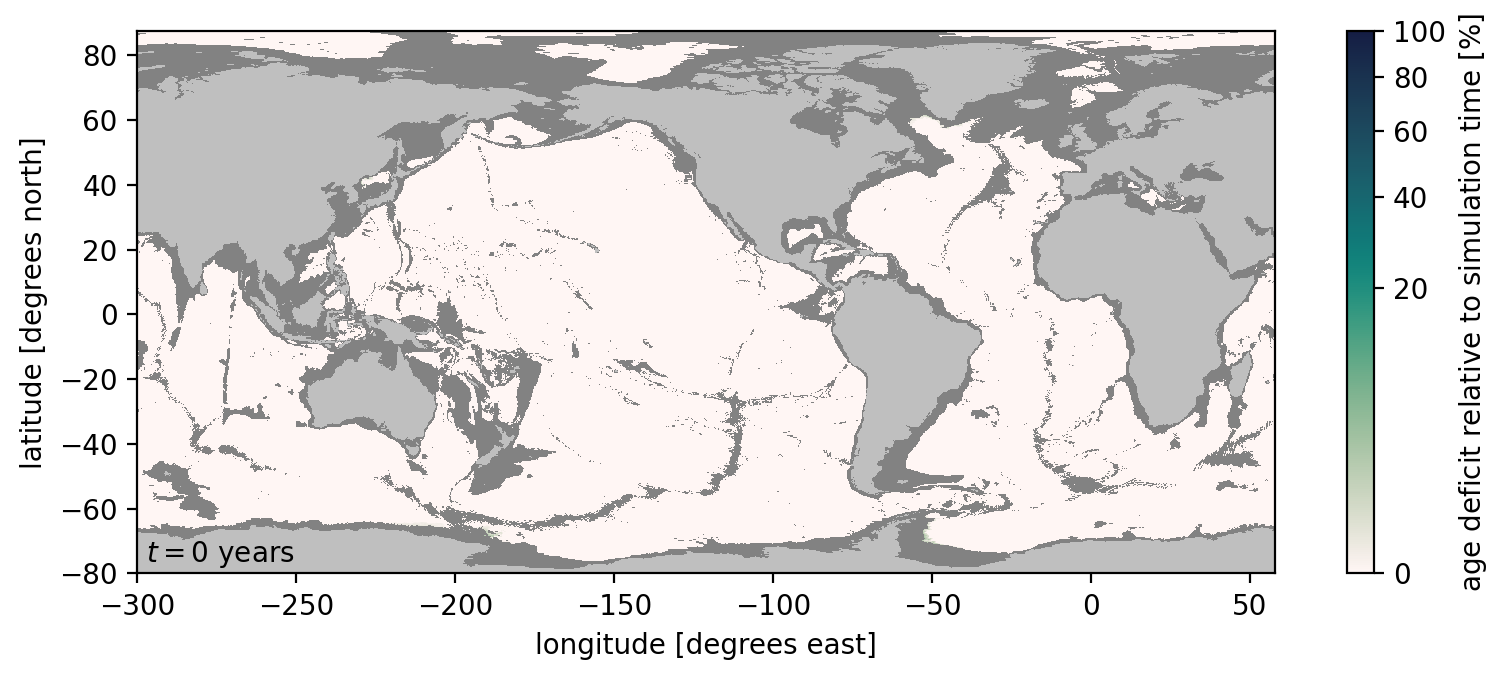

In [319]:
# Initial frame
t = 0
agessc_bottom = ds.agessc.isel(time=t, drop=True).isel(z_l=bottom_idx, drop=True).where(og.deptho.values > 3000)
year = (ds.time.isel(time=t, drop=True).dt.year - 0.5)
age_deficit_bottom = ((year - agessc_bottom)/year) * 100
age_deficit_bottom = age_deficit_bottom.where((age_deficit_bottom >=0) | np.isnan(age_deficit_bottom), 0.)

# Initialize figure
fig, ax = plt.subplots(1,1,figsize=(8, 3.5), dpi=200)
pc = ax.pcolormesh(
    og.geolon_c,
    og.geolat_c,
    scalefactor(age_deficit_bottom),
    cmap=cmap,
    vmin=0, vmax=scalefactor(100), 
)
deep_mask = (og.deptho<3000)
ax.pcolormesh(
    og.geolon_c,
    og.geolat_c,
    deep_mask.where(deep_mask),
    cmap=plt.get_cmap("Greys"),
    vmin=0, vmax=1.75,
)
ax.pcolormesh(
    og.geolon_c,
    og.geolat_c,
    og.deptho.where(og.deptho==0) + 1,
    cmap=plt.get_cmap("Greys"),
    vmin=0, vmax=2.75,
)
dtick = 20
ticks = np.arange(0, 100+dtick, dtick)
cb = plt.colorbar(pc, ax=ax, ticks=scalefactor(ticks), label=r"age deficit relative to simulation time [$\%$]")
cb.ax.set_yticklabels(ticks);
plt.xlabel("longitude [degrees east]")
plt.ylabel("latitude [degrees north]")
plt.ylim(-80, 87.5)
plt.xlim(-300, 58)
plt.tight_layout()
a = plt.annotate(rf"$t = ${t} years", (0,0), xytext=(0.0075, 0.021), textcoords="axes fraction")

def update(t):
    agessc_bottom = ds.agessc.isel(time=t, drop=True).isel(z_l=bottom_idx, drop=True).where(og.deptho.values > 3000)
    year = (ds.time.isel(time=t, drop=True).dt.year - 0.5)
    age_deficit_bottom = ((year - agessc_bottom)/year) * 100
    age_deficit_bottom = age_deficit_bottom.where((age_deficit_bottom >=0) | np.isnan(age_deficit_bottom), 0.)
    
    pc.set_array(scalefactor(age_deficit_bottom.values))
    a.set_text(rf"$t = ${t} years")

In [323]:
ani = animation.FuncAnimation(fig=fig, func=update, frames=ds.time.size, interval=1000/30.)
ani.save("../animations/ideal_age_deficit_at_seafloor_deeper_than_3000m.mp4")